In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pickle
try:
    from Paths_BR import Figure_Save_Path, ePBL_Run_Path, KPP_Run_Path
except:
    from Paths import Figure_Save_Path, ePBL_Run_Path, KPP_Run_Path
plt.rcParams["font.family"] = "Serif"


def fastrsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    n = np.sum(np.isfinite(x),axis=0)
    #Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    # Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    # Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    r2 = 1. - np.sum((y-(x*slope+intercept))**2,axis=0)/np.sum((y-ymean)**2,axis=0)
    return slope,intercept,r2

def fastlinearinterp_nd(xi,yi,xo):
    yo = np.zeros(np.shape(xo))+np.NaN
    
    WRK = np.ones(np.shape(xo),dtype=bool)
    WRK[np.isnan(xi[0,...])] = False
    
    lower= (WRK)&(xo>=xi[-1,...])
    yo[lower] = yi[-1,lower]
    WRK[lower] = False
    
    higher= (WRK)&(xo<=xi[0,...])
    yo[higher] = yi[0,higher]
    WRK[higher] = False
    
    for ii in range(1,np.shape(xi)[0]):
        index = xi[ii,...]>xo
        slope = (yi[ii,(index)&(WRK)]-yi[ii-1,(index)&(WRK)])/(xi[ii,(index)&(WRK)]-xi[ii-1,(index)&(WRK)])
        yo[(WRK)&(index)] = yi[ii-1,(WRK)&(index)]+slope*(xo[(index)&(WRK)]-xi[ii-1,(index)&(WRK)])
        WRK[(WRK)&(index)] = False
    return yo

def Normalize(X):
    X=X-np.nanmean(X)
    X=X/np.nanstd(X)
    return X




    

In [2]:
#Set this flag to True only if you have access to the original model output
DataSource = False

if DataSource:
    LEAD = ePBL_Run_Path
    LEAD2 =KPP_Run_Path
    GRID = 'ocean_monthly/ocean_monthly.static.nc'
    GR1 = xr.open_dataset(LEAD+GRID)
    
    B = xr.open_mfdataset([LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.195801-196212.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196301-196712.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196801-197212.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197301-197712.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197801-198212.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198301-198712.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.MLD_003.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.195801-196212.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196301-196712.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196801-197212.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197301-197712.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197801-198212.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198301-198712.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.MLD_EN1.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.195801-196212.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196301-196712.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196801-197212.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197301-197712.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197801-198212.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198301-198712.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.ePBL_h_ML.nc',
                           LEAD+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.ePBL_h_ML.nc',
                          ])
    K = xr.open_mfdataset([LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.195801-196212.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196301-196712.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196801-197212.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197301-197712.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197801-198212.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198301-198712.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.MLD_003.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.195801-196212.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196301-196712.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196801-197212.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197301-197712.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197801-198212.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198301-198712.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.MLD_EN1.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.195801-196212.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196301-196712.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.196801-197212.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197301-197712.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.197801-198212.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198301-198712.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.198801-199212.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199301-199712.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.199801-200212.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200301-200712.KPP_OBLdepth.nc',
                           LEAD2+'/ocean_monthly/ts/monthly/5yr/ocean_monthly.200801-201212.KPP_OBLdepth.nc',
                          ])

Ocean Station Papa 145W 50N -145 50
Equatorial Pacific 180E 0 -180 0
Labrador Sea 55W 60N -55 60
Southern Ocean 180E 50S -180 -50


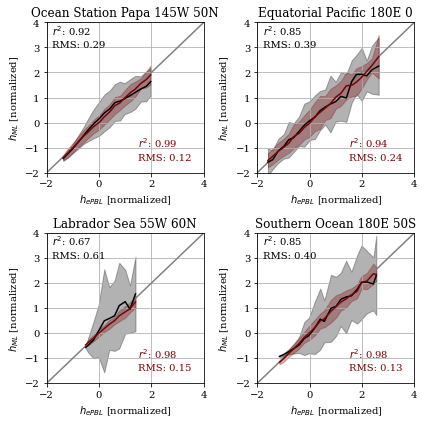

In [3]:

#Create the Stations Figure from the ePBL comparison.

f,a=plt.subplots(2,2,figsize=(6,6))

ii=-1
for XX,YY,Lab,File in[[-145,50,'Ocean Station Papa 145W 50N','ProcessedModelData/OSP.pkl'],
                      [-180,0,'Equatorial Pacific 180E 0','ProcessedModelData/EqP.pkl'],
                      [-55,60,'Labrador Sea 55W 60N','ProcessedModelData/Lab.pkl'],
                      [-180,-50,'Southern Ocean 180E 50S','ProcessedModelData/SO.pkl'],
                     ]:
    ii+=1             
    print(Lab,XX,YY)
    
    if DataSource:
        #Here we generate the data
        
        H=B.sel(xh=XX,yh=YY,method='nearest')
        MLD003 = Normalize(H.MLD_003).values
        MLDEN1 = Normalize(H.MLD_EN1).values
        BLD = Normalize(H.ePBL_h_ML).values

        BI=0.2
        bins=np.arange(-2,3,BI)
        BFr=BI/2
        MLD003b=[];MLD003s=[];
        MLDEN1b=[];MLDEN1s=[]
        BLDb=[];BLDs=[]
        for bi in bins:
            Vals = MLD003[abs(BLD-bi)<BFr]
            if len(Vals)>3:
                MLD003b.append(np.mean(Vals))
                MLD003s.append(np.std(Vals))
            else:
                MLD003b.append(np.NaN)
                MLD003s.append(np.NaN)

            Vals = MLDEN1[abs(BLD-bi)<BFr]
            if len(Vals)>3:
                MLDEN1b.append(np.mean(Vals))
                MLDEN1s.append(np.std(Vals))
            else:
                MLDEN1b.append(np.NaN)
                MLDEN1s.append(np.NaN)

            Vals = BLD[abs(BLD-bi)<BFr]
            if len(Vals)>3:
                BLDb.append(np.mean(Vals))
                BLDs.append(np.std(Vals))
            else:
                BLDb.append(np.NaN)
                BLDs.append(np.NaN)

        MLD003b,MLD003s=np.array(MLD003b),np.array(MLD003s)
        MLDEN1b,MLDEN1s=np.array(MLDEN1b),np.array(MLDEN1s)
        BLDb,BLDs=np.array(BLDb),np.array(BLDs)
        with open(File, 'wb') as FILE:
            pickle.dump([MLD003,MLDEN1,BLD,
                         BLDb,BLDs,MLD003b,MLD003s,MLDEN1b,MLDEN1s],FILE)
    else:
        #Here we just load the pickled data
        
        with open(File, 'rb') as FILE:
            [
                MLD003,MLDEN1,BLD,BLDb,BLDs,MLD003b,MLD003s,MLDEN1b,MLDEN1s
            ]=pickle.load(FILE)
    
    COLS=['gray','black','m','maroon']

    a.ravel()[ii].plot([-5,5],[-5,5],'-',color='gray')
    a.ravel()[ii].fill_between(BLDb,MLD003b-2*MLD003s,MLD003b+2*MLD003s,color=COLS[1],alpha=0.3)
    a.ravel()[ii].fill_between(BLDb,MLDEN1b-2*MLDEN1s,MLDEN1b+2*MLDEN1s,color=COLS[3],alpha=0.3)
    a.ravel()[ii].plot(BLDb,MLD003b,'-',color=COLS[1])
    a.ravel()[ii].plot(BLDb,MLDEN1b,'-',color=COLS[3])
    a.ravel()[ii].set_title(Lab+' '+str(XX)+'E '+str(YY)+'N')
    a.ravel()[ii].set_ylabel(r'$h_{ML}$ [normalized]')
    a.ravel()[ii].set_xlabel(r'$h_{ePBL}$ [normalized]')
    a.ravel()[ii].grid(True)
    a.ravel()[ii].set_xlim(-2,4)
    a.ravel()[ii].set_ylim(-2,4)
    a.ravel()[ii].text(-1.8,3.5,r'$r^2$: {:4.2f}'.format(np.corrcoef(MLD003,BLD)[0,1]**2),color=COLS[1])
    a.ravel()[ii].text(-1.8,3,r'RMS: {:4.2f}'.format(np.sqrt(np.mean((MLD003-BLD)**2))),color=COLS[1])
    a.ravel()[ii].text(1.5,-1,r'$r^2$: {:4.2f}'.format(np.corrcoef(MLDEN1,BLD)[0,1]**2),color=COLS[3])
    a.ravel()[ii].text(1.5,-1.5,r'RMS: {:4.2f}'.format(np.sqrt(np.mean((MLDEN1-BLD)**2))),color=COLS[3])
    a.ravel()[ii].set_title(Lab)
    
f.tight_layout()

f.savefig(Figure_Save_Path+'/Figure9_MLDvBLD_Stations.png')

In [4]:
if DataSource:

    _sl_003,_int_003,_cor_003 = fastrsquared(B.MLD_003,B.ePBL_h_ML)
    _sl_EN1,_int_EN1,_cor_EN1 = fastrsquared(B.MLD_EN1,B.ePBL_h_ML)

    _sl_003_Mar,_int_003_Mar,_cor_003_Mar = fastrsquared(B.MLD_003[2::12,...],B.ePBL_h_ML[2::12,...])
    _sl_EN1_Mar,_int_EN1_Mar,_cor_EN1_Mar = fastrsquared(B.MLD_EN1[2::12,...],B.ePBL_h_ML[2::12,...])

    _sl_003_Sep,_int_003_Sep,_cor_003_Sep = fastrsquared(B.MLD_003[8::12,...],B.ePBL_h_ML[8::12,...])
    _sl_EN1_Sep,_int_EN1_Sep,_cor_EN1_Sep = fastrsquared(B.MLD_EN1[8::12,...],B.ePBL_h_ML[8::12,...])

    import time as time
    _=time.time()
    i=0
    sl_003=_sl_003.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    int_003=_int_003.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    cor_003=_cor_003.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    sl_EN1=_sl_EN1.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    int_EN1=_int_EN1.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    cor_EN1=_cor_EN1.values
    print(i,'...',time.time()-_);_=time.time();i+=1;

    sl_003_Mar=_sl_003_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    int_003_Mar=_int_003_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    cor_003_Mar=_cor_003_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    sl_EN1_Mar=_sl_EN1_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    int_EN1_Mar=_int_EN1_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    cor_EN1_Mar=_cor_EN1_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;

    sl_003_Sep=_sl_003_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    int_003_Sep=_int_003_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    cor_003_Sep=_cor_003_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    sl_EN1_Sep=_sl_EN1_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    int_EN1_Sep=_int_EN1_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    cor_EN1_Sep=_cor_EN1_Sep.values
    
    LON = GR1.geolon
    LAT = GR1.geolat
    #broken up because github won't allow 100mb files
    with open('ProcessedModelData/ePBL1.pkl','wb') as FILE:
        pickle.dump([LON,LAT,cor_003,cor_EN1,sl_003,sl_EN1
                    ],FILE)
    with open('ProcessedModelData/ePBL2.pkl','wb') as FILE:
        pickle.dump([LON,LAT,cor_003_Mar,cor_EN1_Mar,cor_003_Sep,cor_EN1_Sep
                    ],FILE)
else:
    with open('ProcessedModelData/ePBL1.pkl','rb') as FILE:
        [
            LON,LAT,cor_003,cor_EN1,sl_003,sl_EN1
        ]   =pickle.load(FILE) 
    
    with open('ProcessedModelData/ePBL2.pkl','rb') as FILE:
        [
            LON,LAT,cor_003_Mar,cor_EN1_Mar,cor_003_Sep,cor_EN1_Sep
        ]   =pickle.load(FILE) 
    
    

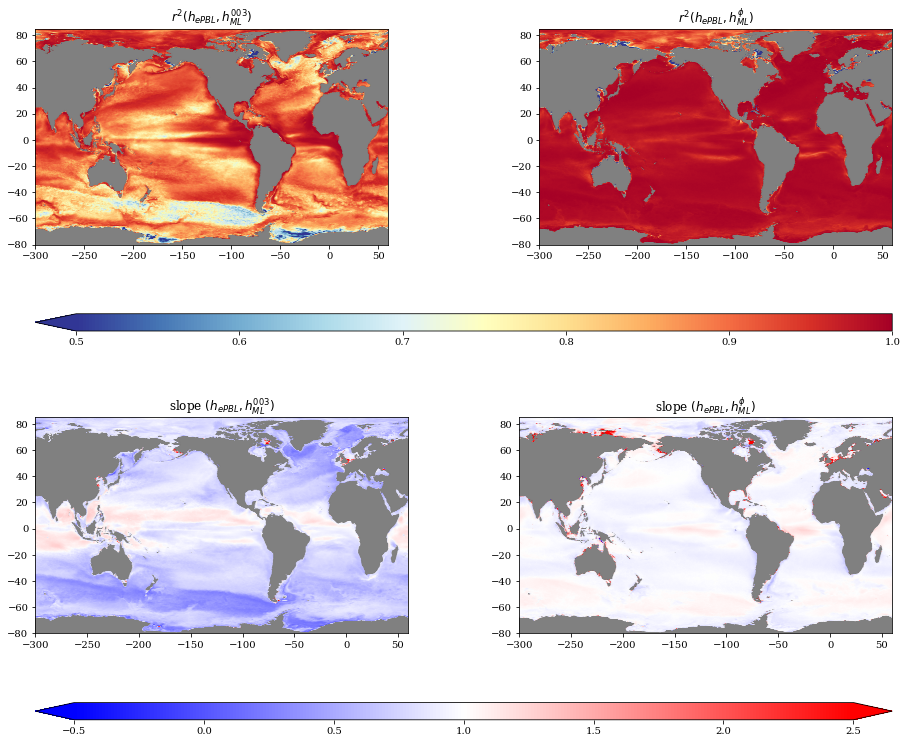

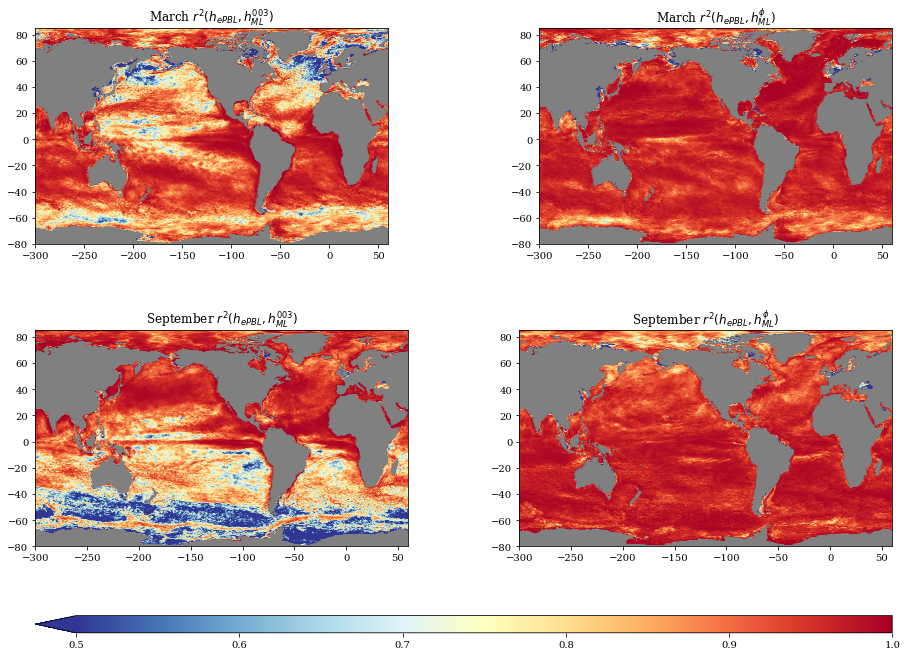

In [5]:
import matplotlib
import copy
CMAP= copy.copy(matplotlib.cm.get_cmap('RdYlBu_r'))
CMAP.set_bad('gray')

SH='nearest' #gives errors
SH='gouraud' #much longer

Ymin=-80
Ymax=85
Xmin=-300
Xmax=60



f=plt.figure(figsize=(14,12))

VMi=0.5
VMa=1
a=f.add_axes([0.1,0.6,0.35,0.25])
CB=a.pcolormesh(LON,LAT,cor_003,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'$r^2(h_{ePBL},h_{ML}^{003})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)
a=f.add_axes([0.6,0.6,0.35,0.25])
a.pcolormesh(LON,LAT,cor_EN1,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'$r^2(h_{ePBL},h_{ML}^{\phi})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)
A=f.add_axes([0.1,0.5,0.85,0.02])
plt.colorbar(CB,cax=A,extend='min',orientation='horizontal')


CMAP2 = copy.copy(matplotlib.cm.get_cmap('bwr'))
CMAP2.set_bad('gray')
VMi=-0.5
VMa=2.5
a=f.add_axes([0.1,0.15,0.37,0.25])
CB=a.pcolormesh(LON,LAT,sl_003,cmap=CMAP2,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'slope $(h_{ePBL},h_{ML}^{003})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)
a=f.add_axes([0.58,0.15,0.37,0.25])
a.pcolormesh(LON,LAT,sl_EN1,cmap=CMAP2,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'slope $(h_{ePBL},h_{ML}^{\phi})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)
A=f.add_axes([0.1,0.05,0.85,0.02])
plt.colorbar(CB,cax=A,extend='both',orientation='horizontal')
f.savefig(Figure_Save_Path+'/Figure10_Map_r2_ePBLvMLD_Year.png')

f=plt.figure(figsize=(14,12))

VMi=0.5
VMa=1
a=f.add_axes([0.1,0.5,0.35,0.25])
CB=a.pcolormesh(LON,LAT,cor_003_Mar,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'March $r^2(h_{ePBL},h_{ML}^{003})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)
a=f.add_axes([0.6,0.5,0.35,0.25])
a.pcolormesh(LON,LAT,cor_EN1_Mar,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'March $r^2(h_{ePBL},h_{ML}^{\phi})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)

VMi=0.5
VMa=1
a=f.add_axes([0.1,0.15,0.37,0.25])
CB=a.pcolormesh(LON,LAT,cor_003_Sep,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'September $r^2(h_{ePBL},h_{ML}^{003})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)
a=f.add_axes([0.58,0.15,0.37,0.25])
a.pcolormesh(LON,LAT,cor_EN1_Sep,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'September $r^2(h_{ePBL},h_{ML}^{\phi})$')
a.set_ylim(Ymin,Ymax)
a.set_xlim(Xmin,Xmax)
A=f.add_axes([0.1,0.05,0.85,0.02])
plt.colorbar(CB,cax=A,extend='min',orientation='horizontal')


f.savefig(Figure_Save_Path+'/Figure11_Map_r2_ePBLvMLD_Months.png')



In [6]:
if DataSource:

    _KP_sl_003,_KP_int_003,_KP_cor_003 = fastrsquared(K.MLD_003,K.KPP_OBLdepth)
    _KP_sl_EN1,_KP_int_EN1,_KP_cor_EN1 = fastrsquared(K.MLD_EN1,K.KPP_OBLdepth)

    _KP_sl_003_Mar,_KP_int_003_Mar,_KP_cor_003_Mar = fastrsquared(K.MLD_003[2::12,...],K.KPP_OBLdepth[2::12,...])
    _KP_sl_EN1_Mar,_KP_int_EN1_Mar,_KP_cor_EN1_Mar = fastrsquared(K.MLD_EN1[2::12,...],K.KPP_OBLdepth[2::12,...])

    _KP_sl_003_Sep,_KP_int_003_Sep,_KP_cor_003_Sep = fastrsquared(K.MLD_003[8::12,...],K.KPP_OBLdepth[8::12,...])
    _KP_sl_EN1_Sep,_KP_int_EN1_Sep,_KP_cor_EN1_Sep = fastrsquared(K.MLD_EN1[8::12,...],K.KPP_OBLdepth[8::12,...])

    import time as time
    _=time.time()
    i=0
    KP_sl_003=_KP_sl_003.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_int_003=_KP_int_003.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_cor_003=_KP_cor_003.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_sl_EN1=_KP_sl_EN1.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_int_EN1=_KP_int_EN1.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_cor_EN1=_KP_cor_EN1.values
    print(i,'...',time.time()-_);_=time.time();i+=1;

    KP_sl_003_Mar=_KP_sl_003_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_int_003_Mar=_KP_int_003_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_cor_003_Mar=_KP_cor_003_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_sl_EN1_Mar=_KP_sl_EN1_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_int_EN1_Mar=_KP_int_EN1_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_cor_EN1_Mar=_KP_cor_EN1_Mar.values
    print(i,'...',time.time()-_);_=time.time();i+=1;

    KP_sl_003_Sep=_KP_sl_003_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_int_003_Sep=_KP_int_003_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_cor_003_Sep=_KP_cor_003_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_sl_EN1_Sep=_KP_sl_EN1_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_int_EN1_Sep=_KP_int_EN1_Sep.values
    print(i,'...',time.time()-_);_=time.time();i+=1;
    KP_cor_EN1_Sep=_KP_cor_EN1_Sep.values
    
    LON = GR1.geolon
    LAT = GR1.geolat
    #broken up because github won't allow 100mb files
    with open('ProcessedModelData/KPP1.pkl','wb') as FILE:
        pickle.dump([LON,LAT,KP_cor_003,KP_cor_EN1,KP_sl_003,KP_sl_EN1
                    ],FILE)
    with open('ProcessedModelData/KPP2.pkl','wb') as FILE:
        pickle.dump([LON,LAT,KP_cor_003_Mar,KP_cor_EN1_Mar,KP_cor_003_Sep,KP_cor_EN1_Sep
                    ],FILE)
else:
    with open('ProcessedModelData/KPP1.pkl','rb') as FILE:
        [
            LON,LAT,KP_cor_003,KP_cor_EN1,KP_sl_003,KP_sl_EN1
        ]   =pickle.load(FILE) 
    
    with open('ProcessedModelData/KPP2.pkl','rb') as FILE:
        [
            LON,LAT,KP_cor_003_Mar,KP_cor_EN1_Mar,KP_cor_003_Sep,KP_cor_EN1_Sep
        ]   =p

NameError: name 'p' is not defined

In [ ]:

import matplotlib
import copy
CMAP= copy.copy(matplotlib.cm.get_cmap('RdYlBu_r'))
CMAP.set_bad('gray')


SH='nearest' #gives errors
SH='gouraud' #much longer


f=plt.figure(figsize=(7,6))

VMi=0.5
VMa=1
a=f.add_axes([0.1,0.6,0.35,0.25])
CB=a.pcolormesh(LON,LAT,KP_cor_003,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'$r^2(h_{KPP},h_{ML}^{003})$')
a=f.add_axes([0.6,0.6,0.35,0.25])
a.pcolormesh(LON,LAT,KP_cor_EN1,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'$r^2(h_{KPP},h_{ML}^{\phi})$')
A=f.add_axes([0.1,0.5,0.85,0.02])
plt.colorbar(CB,cax=A,extend='min',orientation='horizontal')


CMAP2 = copy.copy(matplotlib.cm.get_cmap('bwr'))
CMAP2.set_bad('gray')
VMi=-0.5
VMa=2.5
a=f.add_axes([0.1,0.15,0.37,0.25])
CB=a.pcolormesh(LON,LAT,KP_sl_003,cmap=CMAP2,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'slope $(h_{KPP},h_{ML}^{003})$')
a=f.add_axes([0.58,0.15,0.37,0.25])
a.pcolormesh(LON,LAT,KP_sl_EN1,cmap=CMAP2,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'slope $(h_{KPP},h_{ML}^{\phi})$')
A=f.add_axes([0.1,0.05,0.85,0.02])
plt.colorbar(CB,cax=A,extend='neither',orientation='horizontal')

f.savefig(Figure_Save_Path+'/Figure12_KPP_Map_r2_ePBLvMLD_Year.png')

f=plt.figure(figsize=(7,6))

VMi=0.5
VMa=1
a=f.add_axes([0.1,0.5,0.35,0.25])
CB=a.pcolormesh(LON,LAT,KP_cor_003_Mar,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'March $r^2(h_{KPP},h_{ML}^{003})$')
a=f.add_axes([0.6,0.5,0.35,0.25])
a.pcolormesh(LON,LAT,KP_cor_EN1_Mar,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'March $r^2(h_{KPP},h_{ML}^{\phi})$')

VMi=0.5
VMa=1
a=f.add_axes([0.1,0.15,0.37,0.25])
CB=a.pcolormesh(LON,LAT,KP_cor_003_Sep,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH);
a.set_title(r'September $r^2(h_{KPP},h_{ML}^{003})$')
a=f.add_axes([0.58,0.15,0.37,0.25])
a.pcolormesh(LON,LAT,KP_cor_EN1_Sep,cmap=CMAP,vmin=VMi,vmax=VMa,shading=SH)
a.set_title(r'September $r^2(h_{KPP},h_{ML}^{\phi})$')
A=f.add_axes([0.1,0.05,0.85,0.02])
plt.colorbar(CB,cax=A,extend='min',orientation='horizontal')

f.savefig(Figure_Save_Path+'/Figure13_KPP_Map_r2_ePBLvMLD_Months.png')

